# Identify the 25 hosptials with the highest (and lowest) hospital SHAP values (from a single XGBoost model)

This notebook defines the two sets of 25 hospitals to use as the benchmark hospitals in notebook 210.

## Plain English summary

Here we will use a single XGBoost model trained on all of the data (no test set) and use the SHAP values for each of the one-hot encoded hospital features that make up the *Stroke team* categorical feature, to identify the two sets of 25 "benchmark" hospitals (high and low) to use in the next set of notebooks that explore the effect on patient outcome by using different ways to decide which patient will receive thrombolysis.

SHAP values are in the same units as the model output (for XGBoost these are in log odds). 

## Model and data

Train XGBoost model on all of the data (no test set used) [reuse code from notebook https://github.com/samuel-book/samuel_shap_paper_1/blob/main/xgb_10_features/03a_xgb_all_data_shap_values_vs_feature_values.ipynb]. 

Population to train IVT decision model:
* Scanned within 4 hrs 15 mins of onset
* Just ischaemic
* Include thrombectomy patients

As we are only having patients with ischaemic we can remove this feature in the model: Infarction: Stroke type (1 = infarction, 0 = haemorrhage)

The 9 features in the model are:

* Arrival-to-scan time: Time from arrival at hospital to scan (mins)
* Stroke severity: Stroke severity (NIHSS) on arrival
* Precise onset time: Onset time type (1 = precise, 0 = best estimate)
* Prior disability level: Disability level (modified Rankin Scale) before stroke
* Stroke team: Stroke team attended
* Use of AF anticoagulents: Use of atrial fibrillation anticoagulant (1 = Yes, 0 = No)
* Onset-to-arrival time: Time from onset of stroke to arrival at hospital (mins)
* Onset during sleep: Did stroke occur in sleep?
* Age: Age (as middle of 5 year age bands)

And one target feature:
* Thrombolysis: Did the patient receive thrombolysis (0 = No, 1 = Yes)

Calculate the SHAP values. 

Obtain SHAP values for just the onehot encoded features (reuse code from https://github.com/samuel-book/samuel_shap_paper_1/blob/main/xgb_10_features/03b_xgb_all_data_shap_values_focus_on_ohe_hospitals.ipynb)

Identify the 25 hospitals with the highest SHAP values.

## Aims

* Using XGBoost model fitted on all the data (no test set) using 10 features
* Identify the 25 hospitals with the highest attended SHAP values

## Observations
The 25 hospitals with highest SHAP values (median) are:
* Queen's Medical Centre - Nottingham
* Luton and Dunstable Hospital
* Bronglais Hospital
* James Cook University Hospital
* Charing Cross Hospital HASU
* Queens Hospital Romford HASU
* Royal Berkshire Hospital
* Watford General Hospital
* Queen Alexandra Hospital Portsmouth
* John Radcliffe Hospital
* Southend Hospital
* Morriston Hospital
* University College Hospital HASU
* Royal London Hospital HASU
* Worthing Hospital
* Royal Victoria Infirmary
* University Hospitals of North Tees and Hartlepool
* Addenbrooke's Hospital
* Invicta Ward Kent and Canterbury Hospital
* Basildon University Hospital
* Queen Elizabeth Hospital Kings Lynn
* Northwick Park Hospital HASU
* Whiston Hospital HASU
* Leicester Royal Infirmary
* Ipswich Hospital

Use file in notebook 210: os.path.join(paths.data_save_path, (paths.notebook + paths.model_text + 'highest_25_benchmark_hospitals_median_shap.jpg'))

## Import libraries

In [1]:
# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import machine learning methods
from xgboost import XGBClassifier

from os.path import exists

import shap

from scipy import stats

import os
import pickle
import json

from dataclasses import dataclass

# So can take deep copy
import copy

import time

Report the time duration to run notebook

In [2]:
start_time = time.time()

# Set up paths and filenames
Use os.path.join() to create filenames. So define folders without trailing forward slash, and include all characters in file names.

In [3]:
@dataclass(frozen=True)
class Paths:
    '''Singleton object for storing paths to data and database.'''
    image_save_path: str = './saved_images'
    data_save_path: str = './saved_data'
    model_save_path: str = './saved_models'
    data_read_path: str = '../data_processing/output'
    model_text: str = 'xgb_8_features_all_data_thrombolysis_decision'
    notebook: str = '200_'

paths = Paths()

Define the 9 features to use in the model

It's the 10 features minus Infarction, plus the target feature

In [4]:
selected_features = ["prior_disability", "stroke_severity", 
                     "age", "arrival_to_scan_time", "precise_onset_known", 
                     "onset_to_arrival_time","onset_during_sleep", 
                     "stroke_team", "afib_anticoagulant", 
                     "S2Thrombolysis"]

## Create output folders if needed

In [5]:
path = paths.image_save_path
if not os.path.exists(path):
    os.makedirs(path)
        
path = paths.model_save_path
if not os.path.exists(path):
    os.makedirs(path)

path = paths.data_save_path
if not os.path.exists(path):
    os.makedirs(path)

# Import data
Read in the full dataset (not kfold splits). Include patients that may have had thrombectomy

In [6]:
# Read in training set, restrict to chosen features & store
filename = os.path.join(paths.data_read_path, 
                        '02_reformatted_data_ml_include_mt.csv')
data = pd.read_csv(filename)

Create new feature "S2Thrombolysis" from the surrogate "scan_to_thrombolysis_time"

In [7]:
data["S2Thrombolysis"] = data["scan_to_thrombolysis_time"] > -100

Keep only patients with onset to scan time of 4hours 15mins (so 15 mins to treat). This is 255 minutes.

In [8]:
mask = (data["onset_to_arrival_time"] + data["arrival_to_scan_time"]) <= 255
data = data[mask]

In [9]:
data[["onset_to_arrival_time","arrival_to_scan_time"]]

,onset_to_arrival_time,arrival_to_scan_time
1,170.0,7.0
2,50.0,27.0
4,55.0,101.0
5,84.0,7.0
6,91.0,66.0
...,...,...
171992,72.0,20.0
171994,68.0,17.0
171995,83.0,23.0
171999,123.0,28.0


Only keep selected features

In [10]:
data = data[selected_features]

## Edit data
### Divide into X (features) and y (labels)
We will separate out our features (the data we use to make a prediction) from our label (what we are trying to predict).
By convention our features are called `X` (usually upper case to denote multiple features), and the label (thrombolysis or not) `y`.

In [11]:
X = data.drop('S2Thrombolysis', axis=1)
y = data['S2Thrombolysis']

Average thromboylsis (this is the expected outcome of each patient, without knowing anything about the patient)

In [12]:
print (f'Average treatment: {round(y.mean(),2)}')

Average treatment: 0.4


### One-hot encode hospital feature

In [13]:
# Keep copy of original, with 'Stroke team' not one-hot encoded
X_combined = X.copy(deep=True)

# One-hot encode 'Stroke team'
X_hosp = pd.get_dummies(X['stroke_team'], prefix = 'team')
X = pd.concat([X, X_hosp], axis=1)
X.drop('stroke_team', axis=1, inplace=True)

### Get model feature names 
With one-hot encoded hospitals

In [14]:
# Get a list of the model feature names
feature_names_ohe = list(X.columns)

## XGBoost model

Train an XGBoost model on the full dataset (rather than train/test splits used to assess accuracy).

In [15]:
# Model filename
filename = os.path.join(paths.model_save_path, 
                (paths.notebook + paths.model_text + '.p'))

# Check if exists
file_exists = exists(filename)

if file_exists:
# Load models
    with open(filename, 'rb') as filehandler:
        model = pickle.load(filehandler)
else:
    # Define and Fit model
    model = XGBClassifier(verbosity = 0, seed=42, learning_rate=0.5)
    model.fit(X, y)

    # Save using pickle
    with open(filename, 'wb') as filehandler:
        pickle.dump(model, filehandler)

# Get the predictions for each patient 
#   (the classification, and the probability of being in either class)
y_pred = model.predict(X)
y_pred_proba = model.predict_proba(X)

# Calculate the models accuracy
accuracy = np.mean(y == y_pred)
print(f'Model accuracy: {accuracy:0.3f}')

Model accuracy: 0.832


# SHAP values
SHAP values give the contribution that each feature has on the models prediction, per instance. A SHAP value is returned for each feature, for each instance.

We will use the shap library: https://shap.readthedocs.io/en/latest/index.html

'Raw' SHAP values from XGBoost model are log odds ratios.

## Get SHAP values
TreeExplainer is a fast and exact method to estimate SHAP values for tree models and ensembles of trees. Once set up, we can use this explainer to calculate the SHAP values.

Either load from pickle (if file exists), or calculate.

Setup method to estimate SHAP values (in their default units: log odds)

In [16]:
# SHAP filename
filename_shap_explainer = os.path.join(paths.data_save_path, 
                (paths.notebook + paths.model_text + '_shap_explainer.p'))

# Check if exists
file_exists = exists(filename_shap_explainer)

if file_exists:
    # Load SHAP explainer
    with open(filename_shap_explainer, 'rb') as filehandler:
        explainer = pickle.load(filehandler)
else:
    # Set up method to estimate SHAP values for tree models & ensembles of trees
    explainer = shap.TreeExplainer(model)

    # Save using pickle
    with open(filename_shap_explainer, 'wb') as filehandler:
        pickle.dump(explainer, filehandler)

Calculate SHAP values extended

In [17]:
# SHAP filename
filename_shap_extended = os.path.join(paths.data_save_path, 
                (paths.notebook + paths.model_text + '_shap_values_extended.p'))

file_exists = exists(filename_shap_extended)

if file_exists:
    # Load explainer
    with open(filename_shap_extended, 'rb') as filehandler:
        shap_values_extended = pickle.load(filehandler)
else:
    # Get SHAP values
    shap_values_extended = explainer(X)
    
    # Save using pickle
    with open(filename_shap_extended, 'wb') as filehandler:
        pickle.dump(shap_values_extended, filehandler)

The explainer returns the base value which is the same value for all instances [shap_value.base_values], the shap values per feature [shap_value.values]. It also returns the feature dataset values [shap_values.data]. You can (sometimes!) access the feature names from the explainer [explainer.data_feature_names].

Let's take a look at the data held for the first instance:
* .values has the SHAP value for each of the four features.
* .base_values has the best guess value without knowing anything about the instance.
* .data has each of the feature values

In [18]:
shap_values_extended[0]

.values =
array([ 7.88428113e-02,  1.22653723e+00,  1.77256495e-01,  5.52236080e-01,
        4.19740826e-01,  1.84242688e-02,  2.14082208e-02,  2.92102575e-01,
       -8.54753947e-04, -3.76787735e-04,  3.53058195e-03,  1.51121733e-03,
       -2.93043768e-03,  6.73612638e-04, -2.46711052e-03, -5.46454126e-03,
        1.05936835e-02,  1.88151142e-04,  2.28555800e-04,  1.17092661e-03,
        1.25895650e-03,  4.46742540e-03, -6.58126315e-04, -1.27906050e-03,
        4.89438791e-03,  8.42907280e-03,  2.66260211e-03,  3.37129133e-03,
       -3.17408051e-03,  4.19112941e-04, -3.42174363e-03,  2.78580817e-03,
       -1.23937643e-04,  2.90771201e-03,  6.39348757e-04, -1.56691612e-03,
       -8.90082680e-03, -8.60156864e-03,  3.80028854e-04, -9.52889398e-03,
       -5.54364827e-03, -5.80932479e-03,  5.97988488e-04, -4.49204864e-03,
        1.63130986e-03,  2.87553831e-03, -7.96189532e-04, -1.46330958e-02,
       -1.09474780e-03,  3.43038072e-03,  6.34318800e-04, -1.07290817e-03,
       -2.52988

There is one of these for each instance.

In [19]:
shap_values_extended.shape

(91394, 126)

### Understand SHAP values for the one-hot encoded hospital features 

We've seen above that the categorical feature represented as a one-hot encoded feature have a SHAP value for each of the one-hot encoded features.

For the hospital that the instance attends, the SHAP value for that hosptial represents "the contribution to the prediction due to attending this hospital". For all of the other hosptials for this instance, the SHAP value for those hospitals represents "the contribution to the prediction from not attending this hospital". 

Here we will focus on understanding the SHAP values for each hospital, their contribution when a patient attends the hospital, and the contribution when the patient does not attend the hospital.

#### Format the data 

Features are in the same order in shap_values as they are in the original dataset.

Use this to extract the SHAP values for the one-hot encoded hospital features. Create a dataframe containing the SHAP values: an instance per row, and a one-hot encoded hospital feature per column.

In [20]:
# Get list of one-hot encoded hospital column titles
hospital_names_ohe = X.filter(regex='^team',axis=1).columns
n_hospitals = len(hospital_names_ohe)

# Get list of hospital names without the prefix "team_"
hospital_names = [h[5:] for h in hospital_names_ohe]

# Create list of column indices for these hospital column titles (where do the
#   hospital features exist in the datasets?)
hospital_columns_index = [X.columns.get_loc(col) for col in hospital_names_ohe]
# Use this index list to access the hosptial shap values (as array)
hosp_shap_values = shap_values_extended.values[:,hospital_columns_index]
# Put in dataframe with hospital as column title
df_hosp_shap_values = pd.DataFrame(hosp_shap_values, columns = hospital_names)

Also include four further columns:
1) the hospital that the instance attended
2) contribution from all of the one-hot encoded hospital features
3) contribution from just the hospital attended
4) contribution from not attending the rest

In [21]:
# Include Stroke team that each instance attended
df_hosp_shap_values["stroke_team"] = X_combined["stroke_team"].values

# Store the sum of the SHAP values (for all of the hospital features)
df_hosp_shap_values["all_stroke_teams"] = df_hosp_shap_values.sum(axis=1)

# Initialise list for 1) SHAP value for attended hospital 2) SHAP value for 
#   the sum of the rest of the hospitals
shap_attended_hospital = []
shap_not_attend_these_hospitals = []

# For each patient
for index, row in df_hosp_shap_values.iterrows():

    # Get stroke team attended
    stroke_team = row["stroke_team"]
    
    # Get SHAP value for the stroke team attended
    shap_attended_hospital.append(row[stroke_team])

    # Calculate sum of SHAP values for the stroke teams not attend 
    sum_rest = row["all_stroke_teams"] - row[stroke_team]
    shap_not_attend_these_hospitals.append(sum_rest)

# Store two new columns in dataframe
df_hosp_shap_values["attended_stroke_team"] = shap_attended_hospital
df_hosp_shap_values["not_attended_stroke_teams"] = (
                                            shap_not_attend_these_hospitals)
                   
# View preview
df_hosp_shap_values.head()

,Addenbrooke's Hospital,Basildon University Hospital,Blackpool Victoria Hospital,Bradford and Airedale SU,Bronglais Hospital,Broomfield Hospital,Calderdale Royal Hospital,Charing Cross Hospital HASU,Chesterfield Royal,Colchester General Hospital,...,Worcestershire Royal Hospital,Worthing Hospital,Wycombe General Hospital,Yeovil District Hospital,York Hospital,Ysbyty Gwynedd,stroke_team,all_stroke_teams,attended_stroke_team,not_attended_stroke_teams
0,-0.000855,-0.000377,0.003531,0.001511,-0.002930,0.000674,-0.002467,-0.005465,0.010594,0.000188,...,0.002528,-0.005718,0.000303,-0.001369,0.001118,-0.001014,Royal Victoria Infirmary,0.803913,0.832885,-0.028972
1,-0.002273,-0.000541,0.003204,0.002331,-0.002004,0.002343,-0.002001,-0.008545,0.010119,0.000884,...,0.000376,-0.007829,-0.000849,-0.001537,0.001096,0.001348,Luton and Dunstable Hospital,1.075308,1.146569,-0.071262
2,-0.001682,-0.003666,0.000358,0.002990,-0.003973,0.005957,-0.003739,-0.006672,0.010647,0.003067,...,-0.002982,-0.004921,-0.000741,0.000240,0.000479,0.003034,William Harvey Hospital,-0.057997,-0.016002,-0.041995
3,-0.004796,0.000219,0.004348,0.002362,-0.002947,0.002729,-0.000718,-0.005896,0.011827,0.000261,...,0.002493,-0.007447,-0.000708,-0.001630,0.000547,0.000992,Royal Berkshire Hospital,0.943269,0.955859,-0.012590
4,-0.002804,-0.000888,0.002435,0.003167,-0.002257,0.005953,0.000212,-0.001298,0.014656,-0.001878,...,0.002211,-0.015703,-0.005463,-0.003542,0.001520,0.005717,Pinderfields Hospital,0.633096,0.621849,0.011247


#### Boxplot (all hospitals together)

Analyse the range of SHAP values for the one-hot encoded hospital features. Show as two populations: 1) the attended hospital, 2) the sum of the hospitals not attended

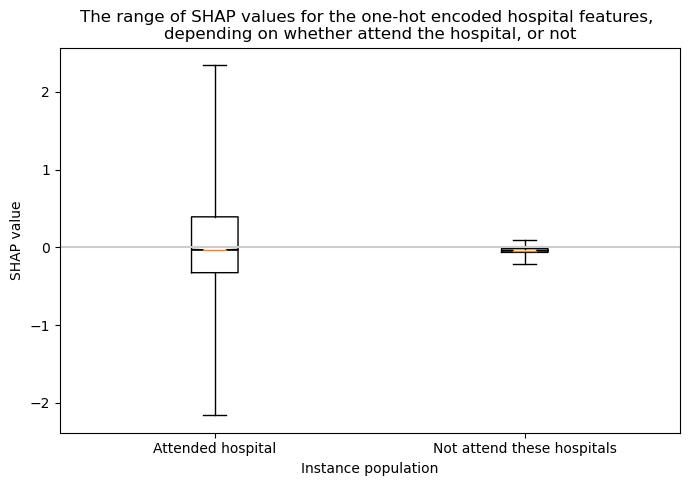

In [22]:
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(1,1,1)
ax.boxplot([shap_attended_hospital, shap_not_attend_these_hospitals],
            labels=["Attended hospital", "Not attend these hospitals"],
            whis=99999, notch=True);
title = ("The range of SHAP values for the one-hot encoded hospital features, "
         "\ndepending on whether attend the hospital, or not")

# Add line at Shap = 0
ax.plot([plt.xlim()[0], plt.xlim()[1]], [0,0], c='0.8') 
    
ax.set_title(title)
ax.set_xlabel("Instance population")
ax.set_ylabel("SHAP value");

filename = os.path.join(paths.image_save_path, 
    (paths.notebook + paths.model_text + 'hosp_shap_attend_vs_notattend_boxplot.jpg'))

plt.savefig(filename, dpi=300, 
            bbox_inches='tight', pad_inches=0.2)
plt.show()

#### Boxplot (individual hospitals)

Create a boxplot to show the range of SHAP values for each individual one-hot encoded hospital feature. 

Show the SHAP value as two populations: 1) the group of instances that attend the hospital [black], and 2) the group of instances that do not attend the hosptial [orange].

Order the hospitals in descending order of mean SHAP value for the hospital the instance attended (so those that more often contribute to a yes-thrombolysis decision, through to those that most often contribute to a no-thrombolysis decision).

Firstly, to order the hospitals, create a dataframe containing the mean SHAP value for each hosptial (for those instances that attended the hospital)

In [23]:
# Initialise lists
attend_stroketeam_min = []
attend_stroketeam_q1 = []
attend_stroketeam_mean = []
attend_stroketeam_median = []
attend_stroketeam_q3 = []
attend_stroketeam_max = []

# For each hospital, store descriptive statistics of SHAP values for those
#   instances that attend the hospital
for h in hospital_names:
    mask = df_hosp_shap_values['stroke_team'] == h
    data_stroke_team = df_hosp_shap_values[h][mask]
    q1, q3 = np.percentile(data_stroke_team, [25,75])
    attend_stroketeam_min.append(data_stroke_team.min())
    attend_stroketeam_q1.append(q1)
    attend_stroketeam_mean.append(data_stroke_team.mean())
    attend_stroketeam_median.append(data_stroke_team.median())
    attend_stroketeam_q3.append(q3)
    attend_stroketeam_max.append(data_stroke_team.max())
    
# Create dataframe with 6 columns
df_hosp_shap_value_stats = pd.DataFrame(hospital_names, columns=["hospital"])
df_hosp_shap_value_stats["shap_min"] = attend_stroketeam_min
df_hosp_shap_value_stats["shap_q1"] = attend_stroketeam_q1
df_hosp_shap_value_stats["shap_mean"] = attend_stroketeam_mean
df_hosp_shap_value_stats["shap_median"] = attend_stroketeam_median
df_hosp_shap_value_stats["shap_q3"] = attend_stroketeam_q3
df_hosp_shap_value_stats["shap_max"] = attend_stroketeam_max

# sort in descending mean SHAP value order
df_hosp_shap_value_stats.sort_values("shap_median", ascending=False, inplace=True)  

# show the 25 hospitals with highest SHAP values (mean of all the attended patients)
df_hosp_shap_value_stats.head(25)

,hospital,shap_min,shap_q1,shap_mean,shap_median,shap_q3,shap_max
4,Bronglais Hospital,0.535766,1.090058,1.265156,1.269490,1.274954,1.903567
44,Morriston Hospital,-0.013082,0.754997,1.006494,0.978208,1.201235,2.340453
66,Royal Berkshire Hospital,0.316830,0.842859,1.007642,0.960929,1.170272,1.957335
39,Luton and Dunstable Hospital,0.349725,0.816098,0.962357,0.958402,1.111144,1.612935
87,Southend Hospital,0.055680,0.693039,0.856942,0.918893,1.010550,1.845684
64,Queen's Medical Centre - Nottingham,0.198647,0.716596,0.918182,0.906027,1.070440,1.789414
60,Queen Alexandra Hospital Portsmouth,-0.069492,0.626851,0.798898,0.807583,0.968021,1.819860
29,James Cook University Hospital,0.309147,0.580420,0.755261,0.765151,0.936310,1.936696
7,Charing Cross Hospital HASU,0.043200,0.595263,0.749595,0.757743,0.913288,1.633519
104,Watford General Hospital,-0.126917,0.585149,0.768886,0.746123,0.915977,1.660533


[Text(0.5, 0, 'SHAP mean'), Text(0, 0.5, 'SHAP median')]

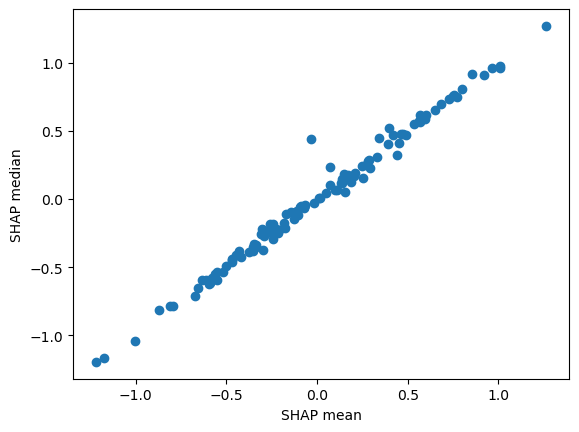

In [24]:
# sort in descending mean SHAP value order
plt.scatter(df_hosp_shap_value_stats["shap_mean"], df_hosp_shap_value_stats["shap_median"])
plt.gca().update(dict(xlabel="SHAP mean",ylabel="SHAP median"))

Print out these hosptials names to use in notebook 201

In [25]:
filename = os.path.join(paths.data_save_path, 
    (paths.notebook + paths.model_text + '_highest_25_benchmark_hospitals_median_shap.csv'))

df_hosp_shap_value_stats["hospital"].head(25).to_csv(filename)

Add admission figures to xlabel in boxplot

Create dataframe with admissions and thrombolysis rate per stroke team (index)

In [26]:
# Get Stroke team name, the stroke team admission numbers, and list of SHAP 
#   values for each instance that attended teh stroke team
unique_stroketeams_list = list(set(X_combined["stroke_team"]))
admissions = [X[f'team_{s}'].sum() for s in unique_stroketeams_list]

df_stroketeam_ivt_adms = pd.DataFrame(unique_stroketeams_list, 
                                      columns=["stroke_team"])
df_stroketeam_ivt_adms["Admissions"] = admissions
df_stroketeam_ivt_adms.set_index("stroke_team", inplace=True)
df_stroketeam_ivt_adms.sort_values("Admissions", ascending=True, inplace=True)

# Calculate IVT rate per hosptial
hosp_ivt_rate = data.groupby(by=["stroke_team"]).mean()["S2Thrombolysis"]

# Join IVT rate with admissions per hosptial
df_stroketeam_ivt_adms = df_stroketeam_ivt_adms.join(hosp_ivt_rate)

df_stroketeam_ivt_adms

,Admissions,S2Thrombolysis
stroke_team,,
Warwick Hospital,69,0.304348
University Hospitals Dorset Stroke Service,173,0.393064
Bronglais Hospital,180,0.650000
West Wales General,208,0.634615
Withybush General Hospital,249,0.554217
...,...,...
Royal Berkshire Hospital,1411,0.625797
Norfolk and Norwich University Hospital,1448,0.331492
Princess Royal Hospital Telford,1462,0.395349


Create data for boxplot. Using order of hospitals from the hosp_shap_stats_df dataframe.

In [27]:
# Go through this order of hospitals
hospital_order = df_hosp_shap_value_stats["hospital"]
    
# Create list of SHAP main effect values (one per hospital) for instances that 
#   attend stroke team
attend_stroketeam_groups_ordered = []
not_attend_stroketeam_groups_ordered = []

# Create list of labels for boxplot "stroke team name (admissions)"
xlabel = []

# Through hospital in defined order (as determined above)
for h in hospital_order:
    # Attend
    mask = df_hosp_shap_values['stroke_team'] == h
    attend_stroketeam_groups_ordered.append(df_hosp_shap_values[h][mask])
    # Not attend
    mask = df_hosp_shap_values['stroke_team'] != h
    not_attend_stroketeam_groups_ordered.append(df_hosp_shap_values[h][mask])
    # Label
    ivt_rate = int(df_stroketeam_ivt_adms['S2Thrombolysis'].loc[h] * 100)
    xlabel.append(f"{h} ({df_stroketeam_ivt_adms['Admissions'].loc[h]}, "
                  f"{ivt_rate}%)")

Plot the boxplot

Resource for using overall y min and max of both datasets on the 4 plots so have the same range: https://blog.finxter.com/how-to-find-the-minimum-of-a-list-of-lists-in-python/#:~:text=With%20the%20key%20argument%20of,of%20the%20list%20of%20lists

Shows the range of contributions to the prediction from this hospital when patients 1) do [black], and 2) do not [orange] attend this hospital


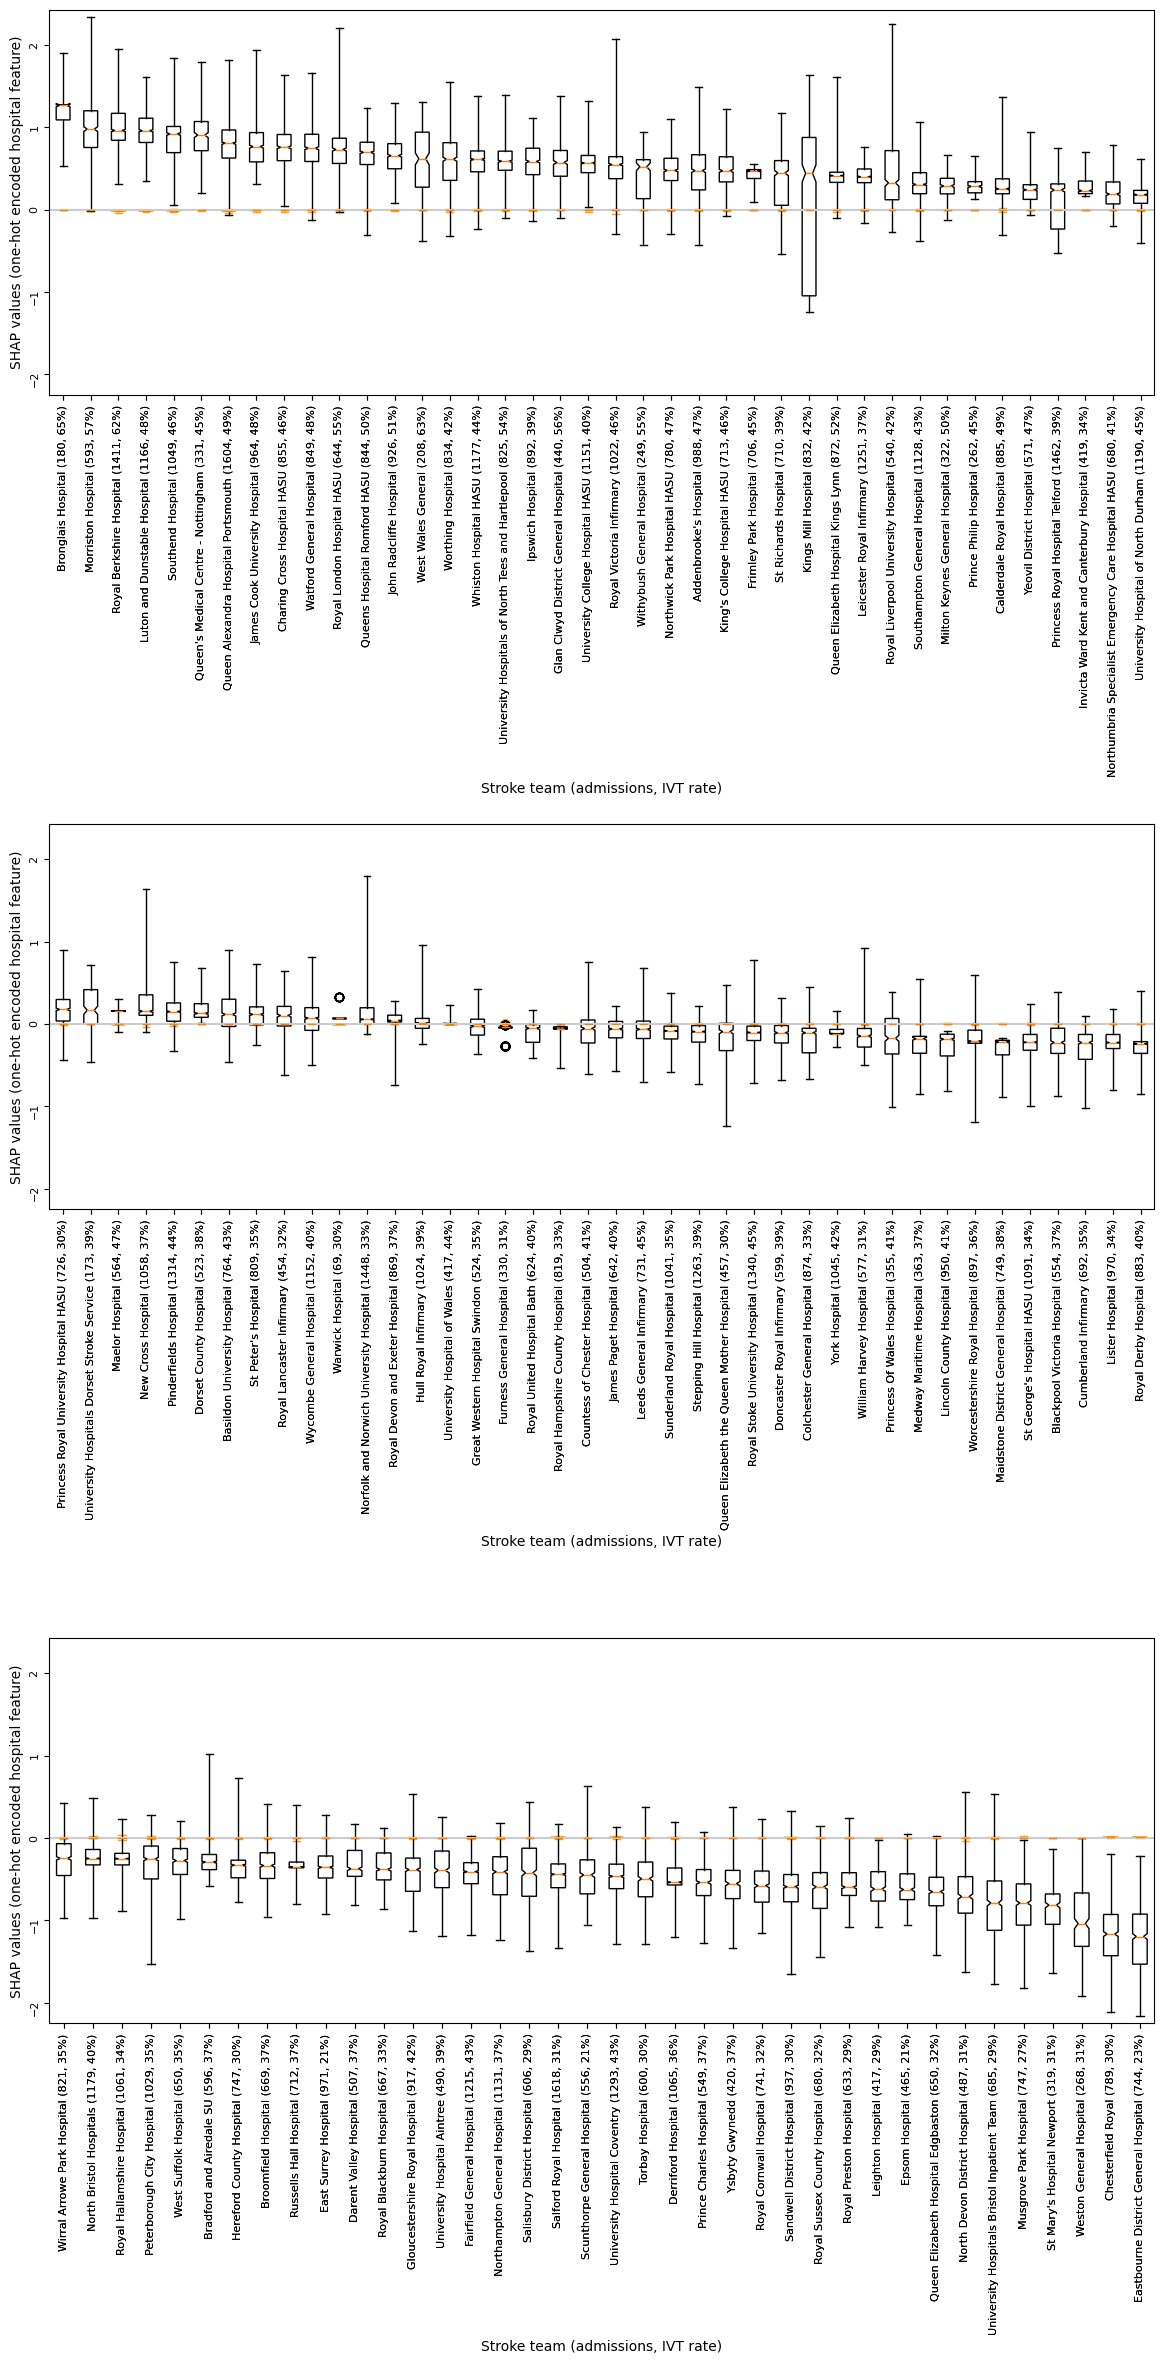

In [28]:
# Plot 34 hospitals on each figure to aid readability
print("Shows the range of contributions to the prediction from this hospital "
      "when patients 1) do [black], and 2) do not [orange] attend this "
      "hospital")

# Group the hospitals into 3 subplots
n_subplots = 3
st = 0
ed = round((n_hospitals/n_subplots)+1)
inc = ed
max_size = n_hospitals

# Use overall y min & max of both datasets on the 4 plots so have same range
ymin1 = min(min(attend_stroketeam_groups_ordered, key=min))
ymin2 = min(min(not_attend_stroketeam_groups_ordered, key=min))
ymax1 = max(max(attend_stroketeam_groups_ordered, key=max))
ymax2 = max(max(not_attend_stroketeam_groups_ordered, key=max))
ymin = min(ymin1, ymin2)
ymax = max(ymax1, ymax2)

# Adjust min and max to accommodate some wriggle room
yrange = ymax - ymin1
ymin = ymin - yrange/50
ymax = ymax + yrange/50

# Create figure with 4 subplots
fig = plt.figure(figsize=(12,8*n_subplots))

# Create four subplots
for subplot in range(n_subplots):
    ax = fig.add_subplot(n_subplots,1,subplot+1)

    # The contribution from this hospital when patients don't attend this 
    #    hospital
    c1 = "orange"
    c2 = "orange"
    c3 = "white"
    ax.boxplot(not_attend_stroketeam_groups_ordered[st:ed],
               labels=xlabel[st:ed],
               whis=99999, patch_artist=True, notch=True,
               boxprops=dict(facecolor=c3, color=c1),
               capprops=dict(color=c1),
               whiskerprops=dict(color=c1),
               flierprops=dict(color=c1, markeredgecolor=c1),
               meanprops=dict(color=c2))
       
    # The contribution from this hospital when patients do attend this hosptial
    c1 = "black"
    c2 = "black"
    c3 = "white"
    ax.boxplot(attend_stroketeam_groups_ordered[st:ed],
               labels=xlabel[st:ed],
               whis=99999, patch_artist=True, notch=True,
               boxprops=dict(facecolor=c3, color=c1),
               capprops=dict(color=c1),
               whiskerprops=dict(color=c1),
               flierprops=dict(color=c1, markeredgecolor=c1),
               meanprops=dict(color=c2))

    plt.gca().update(dict(xlabel='Stroke team (admissions, IVT rate)',
                          ylabel='SHAP values (one-hot encoded hospital feature)',
                          ))
    
    ax.tick_params(axis='both', labelsize=8, rotation=90)
#    plt.labelsize=12
#    plt.xticksrotation=90                          
    plt.ylim(ymin, ymax)    
    # Add line at Shap = 0
    plt.plot([plt.xlim()[0], plt.xlim()[1]], [0,0], c='0.8') 
    st = min(st+inc,max_size)
    ed = min(ed+inc,max_size)

plt.subplots_adjust(bottom=0.25, wspace=0.05)
    
plt.tight_layout(pad=2)

filename = os.path.join(paths.image_save_path, 
    (paths.notebook + paths.model_text + 'individual_hosp_shap_attend_vs_notattend_boxplot.jpg'))

plt.savefig(filename, dpi=300, 
            bbox_inches='tight', pad_inches=0.2)
plt.show()

Notice that when patients do not attend the hospital, the range of the SHAP values are largely centred on zero.
When patients do attend hosptial, the range of SHAP values are largely on one side of zero, or the other.

In [29]:
iqr_below_zero = df_hosp_shap_value_stats["shap_q3"] < 0
iqr_spans_zero = (df_hosp_shap_value_stats["shap_q1"] * 
                  df_hosp_shap_value_stats["shap_q3"])
iqr_above_zero = df_hosp_shap_value_stats["shap_q1"] > 0
iqr_is_zero1 = df_hosp_shap_value_stats["shap_q1"] == 0
iqr_is_zero2 = df_hosp_shap_value_stats["shap_q3"] == 0
iqr_is_zero = iqr_is_zero1 * iqr_is_zero2

print (f"There are {iqr_below_zero.sum()} hospitals whose interquartile range "
       f"is below zero")
print (f"There are {iqr_spans_zero.lt(0).sum()} hospitals whose interquartile "
       f"range spans zero")
print (f"There are {iqr_above_zero.sum()} hospitals whose interquartile range "
       f"is above zero")
print (f"There are {iqr_is_zero.sum()} hospitals whose interquartile range is "
       f"zero")

There are 57 hospitals whose interquartile range is below zero
There are 15 hospitals whose interquartile range spans zero
There are 46 hospitals whose interquartile range is above zero
There are 0 hospitals whose interquartile range is zero


How does the SHAP value for the attended one-hot encoded hospital feature compare to the thrombolysis rate of the hospital?

Create dataframe containing the hospital's IVT rate and SHAP value (for those patients that attend the hospital).

In [30]:
hosp_ivt_rate = data.groupby(by=["stroke_team"]).mean()["S2Thrombolysis"]
df_hosp_plot = (
        df_hosp_shap_value_stats[["shap_median","hospital"]].copy(deep=True))
df_hosp_plot.set_index("hospital", inplace=True)
df_hosp_plot = df_hosp_plot.join(hosp_ivt_rate)
df_hosp_plot

,shap_median,S2Thrombolysis
hospital,,
Bronglais Hospital,1.269490,0.650000
Morriston Hospital,0.978208,0.571669
Royal Berkshire Hospital,0.960929,0.625797
Luton and Dunstable Hospital,0.958402,0.482847
Southend Hospital,0.918893,0.462345
...,...,...
Musgrove Park Hospital,-0.787734,0.271754
St Mary's Hospital Newport,-0.813596,0.319749
Weston General Hospital,-1.037790,0.317164


Plot SHAP value for one-hot encoded hospital feature (mean for those instances that attend the hospital) vs hospital IVT rate

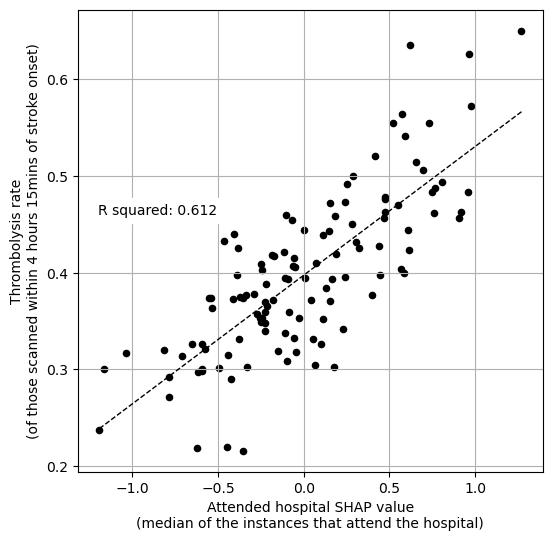

In [31]:
# Setup data for chart
x = df_hosp_plot['shap_median']
y = df_hosp_plot['S2Thrombolysis']

# Fit a regression line to the points
slope, intercept, r_value, p_value, std_err = \
    stats.linregress(x, y)
r_square = r_value ** 2
y_pred = intercept + (x * slope)

# Create scatter plot with regression line
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1)
ax.scatter(x, y, color='black', marker='o', s=20)
ax.plot (x, y_pred, color = 'k', linestyle='--', linewidth=1)

# Set chart limits
#ax.set_ylim(0, 0.5)
#ax.set_xlim(-1.5, 1.5)

# Add textbox
text = f'R squared: {r_square:.3f}'
ax.text(-1.2, 0.46, text, 
         bbox=dict(facecolor='white', edgecolor='white'))

# Chart titles
ax.set_xlabel("Attended hospital SHAP value"
              "\n(median of the instances that attend the hospital)")
ax.set_ylabel('Thrombolysis rate\n(of those scanned within 4 hours 15mins of '
              'stroke onset)')
plt.grid()

filename = os.path.join(paths.image_save_path, 
                        (paths.notebook + paths.model_text + 
                         'attended_hosp_shap_vs_ivt_rate.jpg'))

plt.savefig(filename, dpi=300, 
            bbox_inches='tight', pad_inches=0.2)
plt.show()

In [32]:
f = ('formula: ' + str("{:.2f}".format(slope)) + 'x + ' + 
     str("{:.2f}".format(intercept)))
print (f'R squared: {r_square:.3f}\np: {p_value:0.4f}\nformula: {f}')

R squared: 0.612
p: 0.0000
formula: formula: 0.13x + 0.40
